# [CSCI 3397/PSYC 3317] Lab 2b: Image Features

**Posted:** Saturday, January 29, 2022

**Due:** Thursday, February 3, 2022

__Total Points__: 8 pts

__Submission__: please rename the .ipynb file as __\<your_username\>_lab2b.ipynb__ before you submit it to canvas. Example: weidf_lab2b.ipynb.

# Learning Goals

- Linear filtering: Convolution
- Edge detection: Canny
- Texture analysis: Entropy
- (Optional) Corner detection: Harris

# 1. Linear filtering

## 1.1 Box filter and Gaussian fitler

Let's compute the Gaussian kernel by the mathematical definition. [[Gaussian function]](https://en.wikipedia.org/wiki/Gaussian_function)

(Lec. 4: page 15-16)

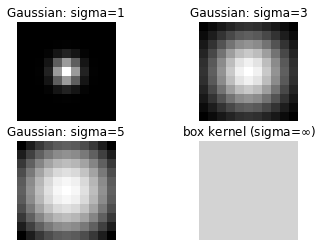

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def getBoxKernel(kernel_size):
    box_kernel = np.ones([kernel_size, kernel_size])
    # make the kernel sum to be 1
    box_kernel = box_kernel/box_kernel.sum()
    return box_kernel

def getGaussianKernel(kernel_size, sigma):
    kernel_size_half = (kernel_size-1) // 2 # // makes sure the division result is int
    xx, yy = np.meshgrid(range(-kernel_size_half,kernel_size_half+1),\
                 range(-kernel_size_half,kernel_size_half+1))  
    gaussian_kernel = 1/(2*np.pi*sigma**2)*np.exp(-(xx**2+yy**2)/(2*sigma**2))
    # make the kernel sum to be 1
    gaussian_kernel = gaussian_kernel/gaussian_kernel.sum() 
    return gaussian_kernel

    
kernel_size = 11
sigmas = [1,3,5]

### Gaussian filter kernel (aka. average filter)
# create 2D coordinate system (x,y)
for i in range(3):
    sigma = sigmas[i]
    gaussian_kernel = getGaussianKernel(kernel_size, sigma)
    plt.subplot(2,2,i+1)
    plt.imshow(gaussian_kernel, cmap='gray')
    plt.title('Gaussian: sigma=%d' % sigma)
    plt.axis('off')
    
### Box filter kernel (aka. average filter)
box_kernel = getBoxKernel(kernel_size)
plt.subplot(224)
plt.imshow(box_kernel, cmap='gray', vmin=0, vmax=0.01)
plt.title('box kernel (sigma=$\infty$)')
plt.axis('off')

plt.show()

## 1.2 Convolution
- Convolution = flip the kernel and do dot product.
- Let's see how Gaussian filter have less "ghosting grid artifact"

(Lec. 4: page 12-13)

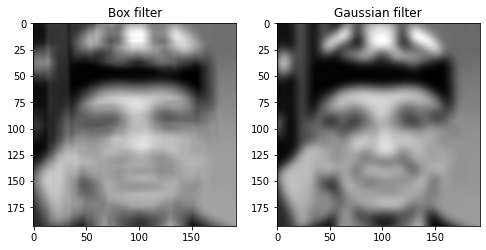

In [21]:
from imageio import imread

def convolution2D(image, kernel):
    # only for gray image
    im_size = np.array(image.shape)
    kernel_size = np.array(kernel.shape)
    # lec. 3: page 54
    # output size for valid conv
    valid_size = im_size - kernel_size + 1
    out = np.zeros(valid_size, np.uint8)
    
    # up-down, left-right flip
    # For box filter and gaussian filter, there's no need to flip as it's symmetric.
    kernel_flip = kernel[::-1, ::-1]
    for row in range(valid_size[0]):
        for col in range(valid_size[1]):
            patch = image[row:row+kernel_size[0], col:col+kernel_size[1]]
            out[row, col] = (patch * kernel_flip).sum()
    return out     

I = imread('lab2/grace_hopper.png')
kernel_size = 21
sigma = 5
# valid convolution
box_kernel = getBoxKernel(kernel_size)
I_box = convolution2D(I, box_kernel)

gaussian_kernel = getGaussianKernel(kernel_size, sigma)
I_gauss = convolution2D(I, gaussian_kernel)

# look at the vertical bar
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(I_box, cmap='gray')
plt.title('Box filter')
plt.subplot(122)
plt.imshow(I_gauss, cmap='gray')
plt.title('Gaussian filter');

## 1.3 Padding
Let's work out an example together. 
- Input: 11x11 image
- Output: "Same" convolution with "constant" padding value 5

[[padding border option]](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)
Lec. 3, page 56 

In [22]:
im_size = np.array([5, 5])
kernel_size = 5
kernel_size_half = (kernel_size - 1)//2


I = np.arange(np.prod(im_size)).reshape(im_size)
pad_size = im_size + kernel_size - 1

# make a bigger image
I_pad = np.ones(pad_size) * 5

# put the original image in the center
I_pad[kernel_size_half : -kernel_size_half,\
      kernel_size_half : -kernel_size_half] = I


box_kernel = getBoxKernel(kernel_size)
I_conv = convolution2D(I_pad, box_kernel)


print('input image\n', I)
print('padded image\n', I_pad)
print('conv output (same)\n', I_conv)

input image
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
padded image
 [[ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  0.  1.  2.  3.  4.  5.  5.]
 [ 5.  5.  5.  6.  7.  8.  9.  5.  5.]
 [ 5.  5. 10. 11. 12. 13. 14.  5.  5.]
 [ 5.  5. 15. 16. 17. 18. 19.  5.  5.]
 [ 5.  5. 20. 21. 22. 23. 24.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]]
conv output (same)
 [[ 5  5  6  6  6]
 [ 6  7  8  8  7]
 [ 8 10 12 11  9]
 [ 9 10 12 11 10]
 [ 8 10 12 11  9]]


## 1.4 2D Filtering with OpenCV
As you now have the hand-on knowledge of convolution, we will directly use OpenCV functions to implement filtering. From now on, please focus on learning how to use these filters (legos) to solve real-world problems.

Syntax:
- Generic filter: `cv2.filter2D(image, -1, kernel matrix)`
- Gaussian: `cv2.GaussianBlur(image, kernel_size, sigma_x, sigma_y)` (if sigma_x=0, it'll be automatically estimated)

[[Tutorial]](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)

In [23]:
import cv2

In [24]:
# if cv2 is not found, install opencv by running the following command
! pip install opencv-python

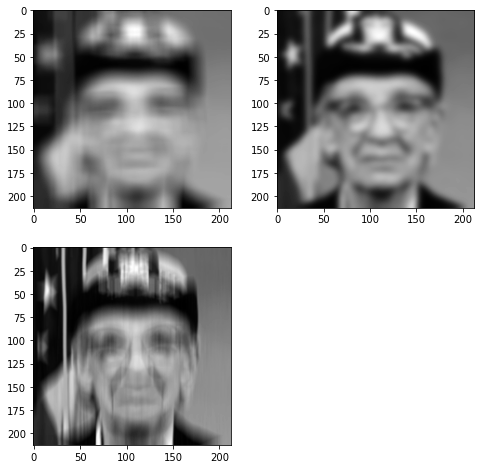

In [25]:
import cv2
I = imread('lab2/grace_hopper.png')
kernel_size = 21
sigma = 5

# Box filter
I_box = cv2.filter2D(I, -1, getBoxKernel(kernel_size))

# motion blur filter
# 1D version of box filter, as if the object moves really fast in one direction
I_mblur = cv2.filter2D(I, -1, np.ones(kernel_size)/kernel_size)

# Gaussian filter
I_gauss = cv2.GaussianBlur(I, (kernel_size,kernel_size), 0)

plt.figure(figsize=(8, 8))
plt.subplot(221);plt.imshow(I_box, cmap='gray')
plt.subplot(222);plt.imshow(I_gauss, cmap='gray')
plt.subplot(223);plt.imshow(I_mblur, cmap='gray')

# 2. Edge detection: Canny
In this section, you will reproduce the edge detection results in the slides.

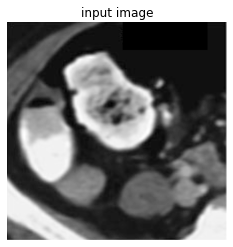

In [26]:
I_cell = imread('lab2/cell_canny_im.png')
plt.imshow(I_cell, cmap='gray')
plt.axis('off')
plt.title('input image');

## 2.1 Robust gradient filtering
Convolve with DoG filter.

Lec. 4, page 24-26

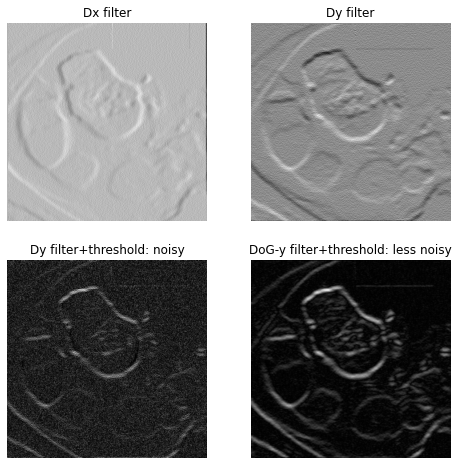

In [27]:
from imageio import imread
import matplotlib.pyplot as plt
import cv2

I_cell2 = I_cell[::2,::2]
I_cell2 = np.clip(I_cell2.astype(float)  +  20 * np.random.random(I_cell2.shape),0,255)

# direct difference filter: [1, -1]
kernel_diff = np.array([1,-1])
Iy = cv2.filter2D(I_cell2, -1, kernel_diff)
Ix = cv2.filter2D(I_cell2, -1, kernel_diff.reshape([1,2]))

# DoG filter
kernel_size = 5
I_guass = cv2.GaussianBlur(I_cell2, [kernel_size,kernel_size], 0)
Iy_DoG = cv2.filter2D(I_guass, -1, kernel_diff)
Ix_DoG = cv2.filter2D(I_guass, -1, kernel_diff.reshape([1,2]))


# show the image
plt.figure(figsize=(8, 8)) 
plt.subplot(221)
plt.imshow(Ix, cmap='gray')
plt.axis('off')
plt.title('Dx filter')

# show the pixel value histogram
plt.subplot(222)
plt.imshow(Iy, cmap='gray')
plt.axis('off')
plt.title('Dy filter')

plt.subplot(223)
plt.imshow(np.abs(Iy), cmap='gray')
plt.axis('off')
plt.title('Dy filter+threshold: noisy')

plt.subplot(224)
plt.imshow(np.abs(Iy_DoG), cmap='gray')
plt.axis('off')
plt.title('DoG-y filter+threshold: less noisy')


plt.show()

## 2.2 Non-maximum suppression

Here's a simplified implementation. Instead of using the estimated gradient direction and interploating the neighboring pixel value, the code below bins the gradient direction in 8 directions so that we can directly get the neighboring pixel with integer location.

<img src="https://i2.wp.com/www.adeveloperdiary.com/wp-content/uploads/2019/05/Implement-Canny-Edge-Detection-Algorithm-using-Python-from-scratch-adeveloperdiary.com-5.jpg">

Lec. 4, page 28

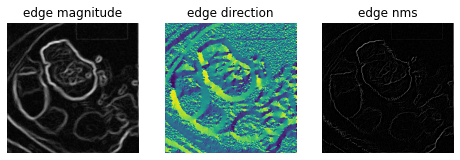

In [28]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    image_row, image_col = gradient_magnitude.shape
    output = np.zeros(gradient_magnitude.shape)
    PI = 180
 
    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col] 
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col] 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col] 
    return output


### DoG_{x,y} -> thick edge
# lec. 4, page 25
Ig_DoG = (Ix_DoG**2 + Iy_DoG**2) ** 0.5

### NMS
Ig_DoG_dir = np.arctan2(Iy_DoG, Ix_DoG)
Ig_DoG_nms = non_max_suppression(Ig_DoG, Ig_DoG_dir)

plt.figure(figsize=(8, 8)) 
plt.subplot(131)
plt.imshow(Ig_DoG, cmap='gray')
plt.axis('off');plt.title('edge magnitude')
plt.subplot(132)
plt.imshow(Ig_DoG_dir)
plt.axis('off');plt.title('edge direction')
plt.subplot(133)
plt.imshow(Ig_DoG_nms, cmap='gray')
plt.axis('off');plt.title('edge nms');

# 3. Texture analysis

## 3.1 Shannon Entropy
Given an 1D array, the Shannon Entropy formula is:
$\mathcal{H} = -\sum_{i} p_i \log_2(p_i)$

Lec. 4, page 42

In [29]:
import numpy as np

def computeEntropy(arr):
    # convert the input to 1D array
    count = np.bincount(np.array(arr).reshape(-1))
    prob = count.astype(float) / count.sum()
    # take the non-zero element (assume 0log(0)=0)
    prob = prob[prob>0]
    H = -(prob * np.log2(prob)).sum()
    return H

for arr in [[0,1,2,3],[2,2,2,2]]:
    print('Array: ',arr)
    print('Entropy: ', computeEntropy(arr))

Array:  [0, 1, 2, 3]
Entropy:  2.0
Array:  [2, 2, 2, 2]
Entropy:  -0.0


# 4. [Optional] Harris corner detection
Here's the one-line function to find corners in your image.

lec. 4, page 45-55  [[OpenCV tutorial]](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html)

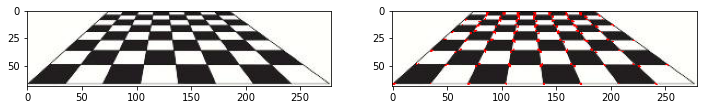

In [30]:
from imageio import imread
import matplotlib.pyplot as plt

img = imread('lab2/checkerboard.jpg')

# Harris corner detection only runs on single-channel image
dst = cv2.cornerHarris(img[:,:,0],2,3,0.04)

# Threshold for an optimal value, it may vary depending on the image.
# mark the corner as red
img_out = img.copy()
img_out[dst>0.1*dst.max()]=[255,0,0]

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_out)


# [8 pts] Exercise

## (1) [2 pts] Median filter  (sec. 1)
One main take-away from the class is the ability to quickly find and learn to use new tools. OpenCV has many image processing algorithms implemented and you need to dig them out. 
- Oh no, the image is corrupted by dirt. Let's denoise it
- Try to look up and find out the (one-line) openCV function to do median filter

Text(0.5, 1.0, 'dirt image')

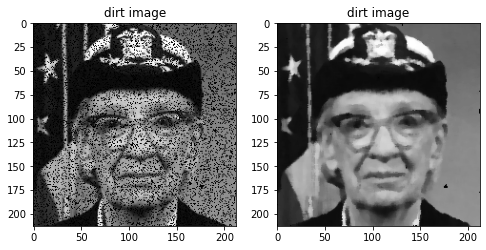

In [31]:
from imageio import imread
import cv2
import numpy as np
import matplotlib.pyplot as plt

I = imread('lab2/grace_hopper.png')
# randomly mask pixels with dirt
dirt_mask = np.random.random(I.shape)>0.8
I_dirt = I.copy()
I_dirt[dirt_mask] = 0

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(I_dirt, cmap='gray')
plt.title('dirt image')

kernel_size = 5
#### your code starts ####
I_fixed = cv2.medianBlur(I_dirt, kernel_size)
#### your code ends ####
plt.subplot(122)
plt.imshow(I_fixed, cmap='gray')
plt.title('dirt image')

## (2) [4 pts] Canny Edge: hysteresis thresholding (sec. 2)

Lec. 4, page 6 (transfer function), page 30 (hysteresis)

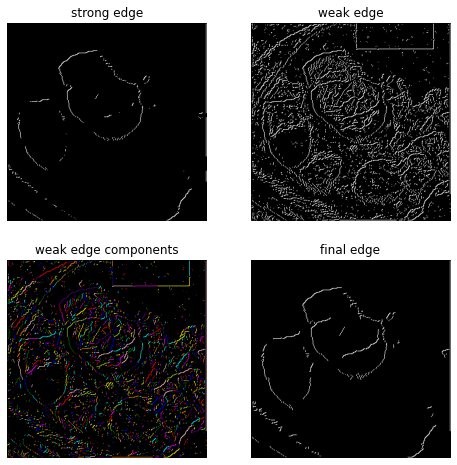

In [32]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np

from skimage.measure import label
from skimage.color import label2rgb

# run cells in section 2 to get Ig_DoG_nms
# btw, the result isn't great as the nms function we used is a simplified version

threshold_high = 20
threshold_low = 3


#### your code starts ####
# input: Ig_DoG_nms
strong_edge = Ig_DoG_nms > threshold_high
weak_edge = Ig_DoG_nms > threshold_low
#### your code ends ####

# step 1. compute connected components
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
weak_edge_components = label(weak_edge, connectivity=2)
# find out which component ids the strong edges have
edge_id = np.unique(weak_edge_components[strong_edge>0]) 


# step 2. bring "connected" weak edge components to the final edge
# pick up all weak edges that have those component ids
# naively, you can do a for loop to add up the mask for each component id
# here, let's use the "transfer" function
relabel = np.zeros(weak_edge_components.max()+1)

#### your code starts ####
# remember the look up table.
# the goal here is to assign ids in `weak_edge_components` to 1 if it's within `edge_id`; 0 otherwise
# by default, all old input pixel values (weak edge component ids) are mapped to 0
# assign the `edge_id` component ids to 1
relabel[edge_id] = 1

# apply the transfer function to weak_edge_components
edge_final = relabel[weak_edge_components]
#### your code ends ####


# show the image
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(strong_edge, cmap='gray')
plt.axis('off')
plt.title('strong edge')

plt.subplot(222)
plt.imshow(weak_edge, cmap='gray')
plt.axis('off')
plt.title('weak edge')

plt.subplot(223)
plt.imshow(label2rgb(weak_edge_components, bg_label=0), cmap='gray')
plt.axis('off')
plt.title('weak edge components')

plt.subplot(224)
plt.imshow(edge_final, cmap='gray')
plt.axis('off')
plt.title('final edge')
plt.show()

## (3) [2 pts] Texture analysis: Find the hidden pattern  (sec. 3)
Lec. 4, page 39

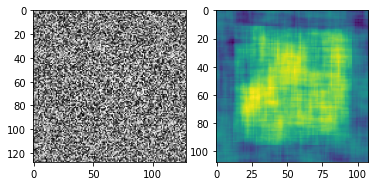

In [33]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np

# run sec. 3 cells first

im = imread('lab2/texture_noise.png')
im_size = np.array(im.shape)

kernel_size = 21
out_size = im_size - kernel_size + 1

out = np.zeros(out_size)
for row in range(out_size[0]):
    for col in range(out_size[1]):
        patch = im[row:row+kernel_size, col:col+kernel_size]
        out[row, col] = computeEntropy(patch)
        
plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.subplot(122)
plt.imshow(out)